All right reserved by #https://github.com/apache/incubator-mxnet/blob/master/docs/tutorials/onnx/fine_tuning_gluon.md

In [1]:
import json
import logging
import multiprocessing
import os
import tarfile

logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import mxnet as mx
from mxnet import gluon, nd, autograd
from mxnet.gluon.data.vision.datasets import ImageFolderDataset
from mxnet.gluon.data import DataLoader
import mxnet.contrib.onnx as onnx_mxnet
import numpy as np

%matplotlib inline

In [2]:
image_folder = "images"
utils_file = "utils.py" # contain utils function to plot nice visualization
base_url = "https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/doc/tutorials/onnx/{}?raw=true"
mx.test_utils.download(base_url.format(utils_file), fname=utils_file)

from utils import *

INFO:root:utils.py exists, skipping download


In [3]:
base_url = "https://s3.amazonaws.com/download.onnx/models/opset_3/"
current_model = "inception_v1"
model_folder = "model"
archive_file = "{}.tar.gz".format(current_model)
archive_path = os.path.join(model_folder, archive_file)
url = "{}{}".format(base_url, archive_file)
onnx_path = os.path.join(model_folder, current_model, 'model.onnx')

# Download the zipped model
mx.test_utils.download(url, dirname = model_folder)

# Extract the model
if not os.path.isdir(os.path.join(model_folder, current_model)):
    print('Extracting {} in {}...'.format(archive_path, model_folder))
    tar = tarfile.open(archive_path, "r:gz")
    tar.extractall(model_folder)
    tar.close()
    print('Model extracted.')


INFO:root:downloaded https://s3.amazonaws.com/download.onnx/models/opset_3/inception_v1.tar.gz into model/inception_v1.tar.gz successfully


Extracting model/inception_v1.tar.gz in model...
Model extracted.


In [6]:
#create data/train, data/val, data/test directories and paste images accordingly 
training_path = "data/train"
print(training_path)
testing_path = "data/val"
print(testing_path)

data/train
data/val


In [7]:
EDGE = 224
SIZE = (EDGE, EDGE)
BATCH_SIZE = 16
NUM_WORKERS = 6

In [8]:
def transform(image, label):
    resized = mx.image.resize_short(image, EDGE)
    cropped, crop_info = mx.image.center_crop(resized, SIZE)
    transposed = nd.transpose(cropped, (2,0,1))
    return transposed, label

In [9]:
dataset_train = ImageFolderDataset(root=training_path)
dataset_test = ImageFolderDataset(root=testing_path)

In [10]:
dataloader_train = DataLoader(dataset_train.transform(transform, lazy=False), batch_size=BATCH_SIZE, last_batch='rollover',
                              shuffle=True, num_workers=NUM_WORKERS)
dataloader_test = DataLoader(dataset_test.transform(transform, lazy=False), batch_size=BATCH_SIZE, last_batch='rollover',
                             shuffle=False, num_workers=NUM_WORKERS)
print("Train dataset: {} images, Test dataset: {} images".format(len(dataset_train), len(dataset_test)))

Train dataset: 844 images, Test dataset: 200 images


Process ForkPoolWorker-12:
Process ForkPoolWorker-7:
Process ForkPoolWorker-9:
Process ForkPoolWorker-8:
Process ForkPoolWorker-1:
Process ForkPoolWorker-6:
Process ForkPoolWorker-2:
Process ForkPoolWorker-10:
Process ForkPoolWorker-11:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/murshed/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/murshed/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/murshed/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/murshed/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/murshed/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    se

  File "/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/ndarray/ndarray.py", line 444, in __setitem__
    self._set_nd_basic_indexing(key, value)
  File "/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/ndarray/ndarray.py", line 710, in _set_nd_basic_indexing
    self._sync_copyfrom(value)
  File "/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/ndarray/ndarray.py", line 876, in _sync_copyfrom
    ctypes.c_size_t(source_array.size)))
KeyboardInterrupt
Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/home/murshed/anaconda3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/murshed/anaconda3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/murshed/anaconda3/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/home/murshed/anaconda3/lib/python3.7/multiprocessing/queues.py", line 351, in get
    

In [11]:
categories = dataset_train.synsets
NUM_CLASSES = len(categories)
BATCH_SIZE = 32

clean


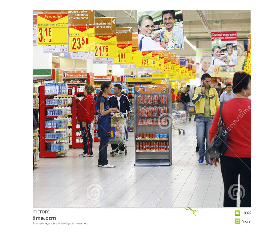

In [12]:
N = 100
plt.imshow((transform(dataset_train[N][0], 0)[0].asnumpy().transpose((1,2,0))))
plt.axis('off')
print(categories[dataset_train[N][1]])

In [13]:
sym, arg_params, aux_params = onnx_mxnet.import_model(onnx_path)
def get_layer_output(symbol, arg_params, aux_params, layer_name):
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.Flatten(data=net)
    new_args = dict({k:arg_params[k] for k in arg_params if k in net.list_arguments()})
    new_aux = dict({k:aux_params[k] for k in aux_params if k in net.list_arguments()})
    return (net, new_args, new_aux)

sym.get_internals()


<Symbol group [data_0, pad0, conv1/7x7_s2_w_0, conv1/7x7_s2_b_0, convolution0, relu0, pad1, pooling0, lrn0, pad2, conv2/3x3_reduce_w_0, conv2/3x3_reduce_b_0, convolution1, relu1, pad3, conv2/3x3_w_0, conv2/3x3_b_0, convolution2, relu2, lrn1, pad4, pooling1, pad5, inception_3a/1x1_w_0, inception_3a/1x1_b_0, convolution3, relu3, pad6, inception_3a/3x3_reduce_w_0, inception_3a/3x3_reduce_b_0, convolution4, relu4, pad7, inception_3a/3x3_w_0, inception_3a/3x3_b_0, convolution5, relu5, pad8, inception_3a/5x5_reduce_w_0, inception_3a/5x5_reduce_b_0, convolution6, relu6, pad9, inception_3a/5x5_w_0, inception_3a/5x5_b_0, convolution7, relu7, pad10, pooling2, pad11, inception_3a/pool_proj_w_0, inception_3a/pool_proj_b_0, convolution8, relu8, concat0, pad12, inception_3b/1x1_w_0, inception_3b/1x1_b_0, convolution9, relu9, pad13, inception_3b/3x3_reduce_w_0, inception_3b/3x3_reduce_b_0, convolution10, relu10, pad14, inception_3b/3x3_w_0, inception_3b/3x3_b_0, convolution11, relu11, pad15, inceptio

In [14]:
new_sym, new_arg_params, new_aux_params = get_layer_output(sym, arg_params, aux_params, 'flatten0')

In [15]:
ctx = mx.gpu() if mx.context.num_gpus() > 0 else mx.cpu()

In [16]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pre_trained = gluon.nn.SymbolBlock(outputs=new_sym, inputs=mx.sym.var('data_0'))
net_params = pre_trained.collect_params()
for param in new_arg_params:
    if param in net_params:
        net_params[param]._load_init(new_arg_params[param], ctx=ctx)
for param in new_aux_params:
    if param in net_params:
        net_params[param]._load_init(new_aux_params[param], ctx=ctx)

In [17]:
dense_layer = gluon.nn.Dense(NUM_CLASSES)
dense_layer.initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)

In [18]:
net = gluon.nn.HybridSequential()
net.hybridize()
with net.name_scope():
    net.add(pre_trained)
    net.add(dense_layer)

In [19]:
softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

In [20]:
LEARNING_RATE = 0.0001
WDECAY = 0.00001
MOMENTUM = 0.9

In [21]:
# ctx = mx.gpu() 
net.collect_params().initialize(ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', 
                        {'learning_rate': LEARNING_RATE,
                         'wd':WDECAY,
                         'momentum':MOMENTUM})

/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'conv1/7x7_s2_w_0' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'conv1/7x7_s2_b_0' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'conv2/3x3_reduce_w_0' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ctx, init, force_reinit=force_reinit)
/home/murshed/anaconda3/lib/python3.7/site-packages/mxnet/gluon/parameter.py:813: UserWarning: Parameter 'conv2/3x3_reduce_b_0' is already initialized, ignoring. Set force_reinit=True to re-initialize.
  v.initialize(None, ct

In [22]:
def evaluate_accuracy_gluon(data_iterator, net):
    num_instance = 0
    sum_metric = nd.zeros(1,ctx=ctx, dtype=np.int32)
    for i, (data, label) in enumerate(data_iterator):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.astype(np.int32).as_in_context(ctx)
        output = net(data)
        prediction = nd.argmax(output, axis=1).astype(np.int32)
        num_instance += len(prediction)
        sum_metric += (prediction==label).sum()
    accuracy = (sum_metric.astype(np.float32)/num_instance)
    return accuracy.asscalar()


In [23]:
%%time
print("Untrained network Test Accuracy: {0:.4f}".format(evaluate_accuracy_gluon(dataloader_test, net)))

Untrained network Test Accuracy: 0.4948
CPU times: user 880 ms, sys: 811 ms, total: 1.69 s
Wall time: 1.33 s


In [25]:
val_accuracy = 0
for epoch in range(10):
    for i, (data, label) in enumerate(dataloader_train):
        data = data.astype(np.float32).as_in_context(ctx)
        label = label.as_in_context(ctx)

        if i%20==0 and i >0:
            print('Batch [{0}] loss: {1:.4f}'.format(i, loss.mean().asscalar()))

        with autograd.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(data.shape[0])

    nd.waitall() # wait at the end of the epoch    
    new_val_accuracy = evaluate_accuracy_gluon(dataloader_test, net)    
    print("Epoch [{0}] Test Accuracy {1:.4f} ".format(epoch, new_val_accuracy))

#     # We perform early-stopping regularization, to prevent the model from overfitting
#     if val_accuracy > new_val_accuracy:
#         print('Validation accuracy is decreasing, stopping training')
#         break
    val_accuracy = new_val_accuracy

Batch [20] loss: 0.5064
Batch [40] loss: 0.3590
Epoch [0] Test Accuracy 0.8229 
Batch [20] loss: 0.4360
Batch [40] loss: 0.2418
Epoch [1] Test Accuracy 0.8750 
Batch [20] loss: 0.3828
Batch [40] loss: 0.1382
Epoch [2] Test Accuracy 0.8490 
Batch [20] loss: 0.3465
Batch [40] loss: 0.2845
Epoch [3] Test Accuracy 0.8654 
Batch [20] loss: 0.6949
Batch [40] loss: 0.1507
Epoch [4] Test Accuracy 0.8750 
Batch [20] loss: 0.1246
Batch [40] loss: 0.1330
Epoch [5] Test Accuracy 0.8750 
Batch [20] loss: 0.1307
Batch [40] loss: 0.2287
Epoch [6] Test Accuracy 0.8802 
Batch [20] loss: 0.1464
Batch [40] loss: 0.4150
Epoch [7] Test Accuracy 0.8894 
Batch [20] loss: 0.1217
Batch [40] loss: 0.1922
Epoch [8] Test Accuracy 0.8906 
Batch [20] loss: 0.2536
Batch [40] loss: 0.3016
Epoch [9] Test Accuracy 0.8942 


In [26]:
#Save net parameters
net.export(current_model, 100)
saved_model = current_model + '.params'
print (saved_model)
net.save_parameters(saved_model)

inception_v1.params


In [27]:
def transform(img):
    return nd.array(np.expand_dims(np.transpose(img, (2,0,1)),axis=0).astype(np.float32), ctx=ctx)

In [28]:
import os
import subprocess
import time
import cv2
import psutil

#This is the path of the images for testing
path = os.getcwd() + '/data/test'

#folders = []

files = os.listdir(path)
#print (files)

images = {}
false_assum = {}

for file in files:
   if 'hazard' in file:
      images.update({file : 'hazard'})
   elif 'clean' in file:
      images.update({file : 'clean'})

#print (images)

total_time = 0
for key in images:
   print ('\n\nImage name : ',key, 'Tag: ' , images[key], 'floor and the classification result is : ' )
   
   img = cv2.imread(path+'/'+key)
   img = cv2.resize(img,(224,224))
   #img = np.reshape(img,[1,224,224,3])
   #image = tf.cast(img, tf.float32)
   image = transform(img)
   start_time = time.time()
   classes = net(image)
   total_time = total_time + (time.time()-start_time)
   print(classes)
   pid = os.getpid()
   py = psutil.Process(pid)
   memoryUse = py.memory_info()[0]/2.**30  # memory use in GB...I think
   cpuusage = py.cpu_percent()
   print('memory use:', memoryUse)
   print('cpu use:', cpuusage)
   if classes[0][0] > classes[0][1]:
        res = 'clean'
        print('clean')
   else:
        res = 'hazard'
        print('hazard')
   
#    print("---%s seconds ---" % (time.time() - start_time))
   print("Image Name", key ,"classify as : ", res )
   if images[key] in res:
      images[key] = 1
   else:
      images[key] = 0
      false_assum.update({key: 0})
print("Total avg inference time: ", total_time/138)

print ("List of wrong assumtion : ", false_assum)
print ('########## Final result #########')
print ('Total right assumtion : ', sum(images.values()), '\nTotal worng assumtion : ', len(images)-sum(images.values()), '\nModel accuracy = ', round((sum(images.values())*100)/len(images), 3), '%')



Image name :  clean_62.jpg Tag:  clean floor and the classification result is : 

[[-0.02978915 -0.71335244]]
<NDArray 1x2 @gpu(0)>
memory use: 4.365497589111328
cpu use: 0.0
clean
Image Name clean_62.jpg classify as :  clean


Image name :  clean_53.jpg Tag:  clean floor and the classification result is : 

[[ 1.0060489 -2.4147036]]
<NDArray 1x2 @gpu(0)>
memory use: 4.365802764892578
cpu use: 0.0
clean
Image Name clean_53.jpg classify as :  clean


Image name :  clean_29.jpg Tag:  clean floor and the classification result is : 

[[-0.44078866 -0.39552793]]
<NDArray 1x2 @gpu(0)>
memory use: 4.365802764892578
cpu use: 0.0
hazard
Image Name clean_29.jpg classify as :  hazard


Image name :  hazard_44.jpg Tag:  hazard floor and the classification result is : 

[[-2.4997394  1.9971884]]
<NDArray 1x2 @gpu(0)>
memory use: 4.365802764892578
cpu use: 0.0
hazard
Image Name hazard_44.jpg classify as :  hazard


Image name :  hazard_3.jpg Tag:  hazard floor and the classification result is : 




[[-0.38582918  0.37314272]]
<NDArray 1x2 @gpu(0)>
memory use: 4.3658599853515625
cpu use: 0.0
hazard
Image Name clean_50.jpg classify as :  hazard


Image name :  clean_11.jpg Tag:  clean floor and the classification result is : 

[[-0.6914323 -1.1701732]]
<NDArray 1x2 @gpu(0)>
memory use: 4.3658599853515625
cpu use: 0.0
clean
Image Name clean_11.jpg classify as :  clean


Image name :  hazard_56.jpg Tag:  hazard floor and the classification result is : 

[[-1.169566   -0.01051079]]
<NDArray 1x2 @gpu(0)>
memory use: 4.3658599853515625
cpu use: 0.0
hazard
Image Name hazard_56.jpg classify as :  hazard


Image name :  clean_38.jpg Tag:  clean floor and the classification result is : 

[[0.83797735 0.50258845]]
<NDArray 1x2 @gpu(0)>
memory use: 4.3658599853515625
cpu use: 0.0
clean
Image Name clean_38.jpg classify as :  clean


Image name :  clean_4.jpg Tag:  clean floor and the classification result is : 

[[-0.26355737 -1.8903663 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.3658599853515625



[[ 0.46134326 -1.8006103 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375
cpu use: 0.0
clean
Image Name hazard_28.jpg classify as :  clean


Image name :  hazard_30.jpg Tag:  hazard floor and the classification result is : 

[[-2.391073   -0.85543925]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375
cpu use: 0.0
hazard
Image Name hazard_30.jpg classify as :  hazard


Image name :  clean_57.jpg Tag:  clean floor and the classification result is : 

[[-0.71351045 -0.19583343]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375
cpu use: 0.0
hazard
Image Name clean_57.jpg classify as :  hazard


Image name :  clean_32.jpg Tag:  clean floor and the classification result is : 

[[-0.05993149 -1.282625  ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375
cpu use: 0.0
clean
Image Name clean_32.jpg classify as :  clean


Image name :  hazard_10.jpg Tag:  hazard floor and the classification result is : 

[[-0.6174788  0.5049715]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375


[[ 0.33823487 -0.87120575]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375
cpu use: 0.0
clean
Image Name clean_58.jpg classify as :  clean


Image name :  clean_30.jpg Tag:  clean floor and the classification result is : 

[[ 3.425484  -1.1854333]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375
cpu use: 0.0
clean
Image Name clean_30.jpg classify as :  clean


Image name :  clean_36.jpg Tag:  clean floor and the classification result is : 

[[ 1.0060489 -2.4147036]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375
cpu use: 0.0
clean
Image Name clean_36.jpg classify as :  clean


Image name :  hazard_20.jpg Tag:  hazard floor and the classification result is : 

[[-4.133485    0.98052466]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375
cpu use: 0.0
hazard
Image Name hazard_20.jpg classify as :  hazard


Image name :  hazard_46.jpg Tag:  hazard floor and the classification result is : 

[[-0.91543394  1.1698143 ]]
<NDArray 1x2 @gpu(0)>
memory use: 4.366302490234375
cpu 

In [29]:
# Number of predictions to show (optional)
TOP_P = 1
images = os.listdir("images")

# Convert img to format expected by the network
def transform(img):
    return nd.array(np.expand_dims(np.transpose(img, (2,0,1)),axis=0).astype(np.float32), ctx=ctx)

# Load and transform the test images
caltech101_images_test = [plt.imread(os.path.join(image_folder, "{}".format(img))) for img in images]
caltech101_images_transformed = [transform(img) for img in caltech101_images_test]

In [30]:
def run_batch(net, data):
    results = []
    for batch in data:
        outputs = net(batch)
        results.extend([o for o in outputs.asnumpy()])
    return np.array(results)

In [31]:
#image should be 224*224
result = run_batch(net, caltech101_images_transformed)

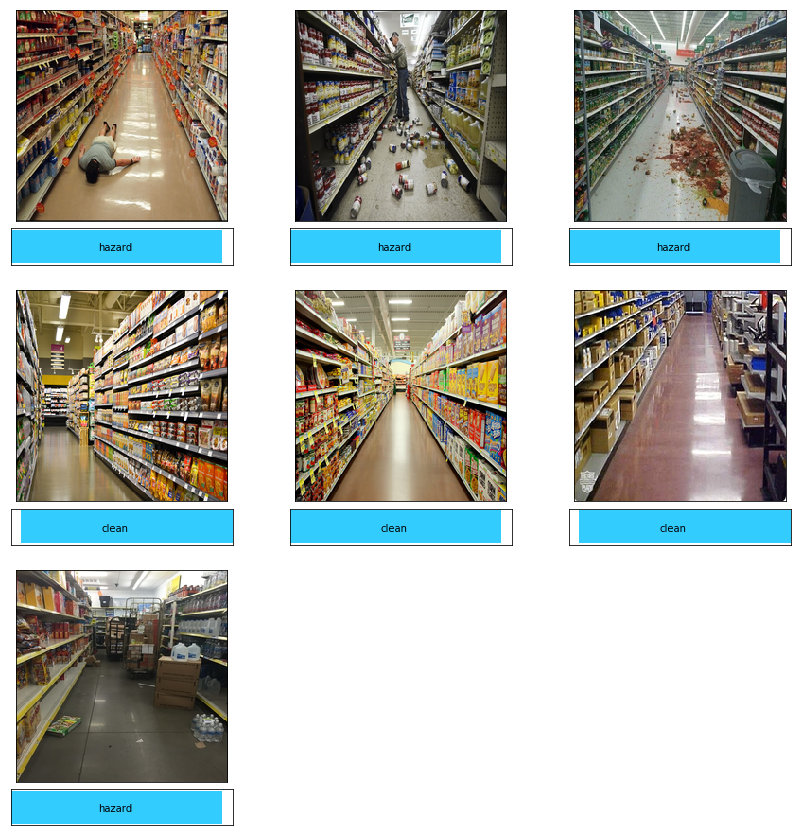

In [32]:
plot_predictions(caltech101_images_test, result, categories, TOP_P)